# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [11]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 1: Data Preparation

In [12]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv')

/home/feyan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [ ]:
print('Azdias:', azdias.shape)
print('Customers:', customers.shape)

Azdias: (891221, 366)
Customers: (191652, 369)


In [ ]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [ ]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [ ]:
# Differences in columns of two datasets
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [ ]:
# Count how many columns having nan values
print((azdias.isna().sum()>0).sum(), "columns in azidas have nan.")
print((customers.isna().sum()>0).sum(), "columns in customers have nan.")

273 columns in azidas have nan.
273 columns in customers have nan.


In [ ]:
# Count dtypes in columns
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [ ]:
azdias.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W


In [ ]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [ ]:
customers.select_dtypes(['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1.0,13.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5.0,34.0,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4.0,24.0,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7.0,41.0,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


### 1.1 Dtype warining
When load the origin data, the warning is shown: DtypeWarning: Columns (18,19) have mixed types. 
X and XX values in columns 18 and 19, that need to be converted to NANs.

In [ ]:
azdias.columns[18:20]

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [ ]:
azdias[['CAMEO_INTL_2015','CAMEO_DEUG_2015']]

,CAMEO_INTL_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,51.0,8.0
2,24.0,4.0
3,12.0,2.0
4,43.0,6.0
...,...,...
891216,41.0,7.0
891217,51.0,9.0
891218,24.0,4.0
891219,51.0,9.0


In [ ]:
azdias['CAMEO_INTL_2015'].value_counts()

51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0     7983
34.0     7787
12       7645
15.0     7142
44.0     6277
35       6090
32       6067
33       5833
12.0     5604
32.0     4287
35.0     4266
33.0     4102
XX        373
Name: CAMEO_INTL_2015, dtype: int64

In [ ]:
azdias['CAMEO_DEUG_2015'].value_counts()

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64

In [13]:
def convert_nan(df,col_name):
    df[col_name] = df[col_name].replace({'X': np.nan, 'XX': np.nan})
    df[col_name] = df[col_name].astype(float)

In [14]:
azdias_replaced = azdias.copy()
customers_replaced = customers.copy()

for df in [azdias_replaced,customers_replaced]:
    for col_names in ['CAMEO_INTL_2015','CAMEO_DEUG_2015']:
        convert_nan(df,col_names)

In [ ]:
azdias_replaced['CAMEO_DEUG_2015'].value_counts()

8.0    134441
9.0    108177
6.0    105874
4.0    103912
3.0     86779
2.0     83231
7.0     77933
5.0     55310
1.0     36212
Name: CAMEO_DEUG_2015, dtype: int64

In [ ]:
azdias_replaced['CAMEO_INTL_2015'].value_counts()

51.0    133694
41.0     92336
24.0     91158
14.0     62884
43.0     56672
54.0     45391
25.0     39628
22.0     33155
23.0     26750
13.0     26336
45.0     26132
55.0     23955
52.0     20542
31.0     19024
34.0     18524
15.0     16974
44.0     14820
12.0     13249
35.0     10356
32.0     10354
33.0      9935
Name: CAMEO_INTL_2015, dtype: int64

In [15]:
# drop the columns which are only in customers data
customers_replaced.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'] , axis=1, inplace=True)

### 1.2 Missing values

#### 1.2.0 Explore attributes data 

In [17]:
attributes_values = pd.read_excel('data/DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [18]:
attributes_values

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
...,...,...,...,...,...
2253,NaN,NaN,NaN,2,smart
2254,NaN,NaN,NaN,3,fair supplied
2255,NaN,NaN,NaN,4,price driven
2256,NaN,NaN,NaN,5,seeking orientation


In [ ]:
attributes_info

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...,...
308,NaN,Community,ARBEIT,share of unemployed person in the community,NaN
309,NaN,NaN,EINWOHNER,inhabitants,NaN
310,NaN,NaN,GKZ,standardized community-code,NaN
311,NaN,NaN,ORTSGR_KLS9,classified number of inhabitants,NaN


In [ ]:
attributes_info['Information level'].unique()

array([nan, 'Person', 'Household', 'Building', 'Microcell (RR4_ID)',
       'Microcell (RR3_ID)', '125m x 125m Grid', 'Postcode ', 'RR1_ID',
       'PLZ8', 'Community'], dtype=object)

In [ ]:
# attributes are not in customers file
set(customers.columns)-set(attributes_info.Attribute.values)

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'CUSTOMER_GROUP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24'

In [ ]:
# check explaination of columns in "DIAS Information Levels - Attributes 2017.xlsx"
# CAMEO_INTL_2015 is CAMEO_DEUINTL_2015 in attribute file
attributes_info[attributes_info["Attribute"].isin(['CAMEO_DEUG_2015','CAMEO_DEUINTL_2015'])]

,Unnamed: 0,Information level,Attribute,Description,Additional notes
85,NaN,Microcell (RR4_ID),CAMEO_DEUG_2015,CAMEO_4.0: uppergroup,New German CAMEO Typology established together...
87,NaN,NaN,CAMEO_DEUINTL_2015,CAMEO_4.0: international classification,NaN


##### 1.2.0.1 Some values are "unknown" and "no transactions known" in Attribute "Meaning". 
We need to convert them to NaN

In [19]:
attributes_missing = attributes_values[attributes_values['Meaning'].isin(['unknown','unknown / no main age detectable','no transactions known','no transaction known'])]
attributes_missing

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,NaN,ANREDE_KZ,gender,"-1, 0",unknown
40,NaN,BALLRAUM,distance to next urban centre,-1,unknown
...,...,...,...,...,...
2219,NaN,WOHNDAUER_2008,length of residence,"-1, 0",unknown
2229,NaN,WOHNLAGE,residential-area,-1,unknown
2238,NaN,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,NaN,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown


In [20]:
# get dict for unknown rows
def get_unknown_dict(df):
    unknown_values = []
    for val in df.Value:
        if isinstance(val, int):
            unknown_values.append([val])
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown_values.append(int_list)

    unknown_dict = {}
    for attr, value_list in zip(df.Attribute, unknown_values):
        unknown_dict[attr] = value_list

    return unknown_dict

In [21]:
unknown_dict = get_unknown_dict(attributes_missing)
unknown_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ALTER_HH': [0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_BANKEN_ANZ_12': [0],
 'D19_BANKEN_ANZ_24': [0],
 nan: [-1, 9],
 'D19_BANKEN_DIREKT_RZ': [0],
 'D19_BANKEN_GROSS_RZ': [0],
 'D19_BANKEN_LOKAL_RZ': [0],
 'D19_BANKEN_REST_RZ': [0],
 'D19_BEKLEIDUNG_GEH_RZ': [0],
 'D19_BEKLEIDUNG_REST_RZ': [0],
 'D19_BILDUNG_RZ': [0],
 'D19_BIO_OEKO_RZ': [0],
 'D19_BUCH_RZ': [0],
 'D19_DIGIT_SERV_RZ': [0],
 'D19_DROGERIEARTIKEL_RZ': [0],
 'D19_ENERGIE_RZ': [0],
 'D19_FREIZEIT_RZ': [0],
 'D19_GARTEN_RZ': [0],
 'D19_GESAMT_ANZ_12': [0],
 'D19_GESAMT_ANZ_24': [0],
 'D19_HANDWERK_RZ': [0],
 'D19_HAUS_DEKO_RZ': [0],
 'D19_KINDERARTIKEL_RZ': [0],
 'D19_KK_KUNDENTYP': [-1],
 'D19_KOSMETIK_RZ': [0],
 'D19_LEBENSMITTEL_RZ': [0],
 'D19_LOTTO_RZ': [0],
 'D19_NAHRUNGSERGAENZUNG_RZ': [0],
 'D19_RATGEBER_RZ': [0],
 'D19_REISEN_RZ': [0],
 'D19_SAMMELARTIKEL_

In [22]:
#Converts unknown values to NaN in azdias and customers data based on unknown_dict.
# Some keys are not in azdias or customers, need to skip
def convert_unknown(df,unknown_dict):
    for (key,value) in unknown_dict.items():
        try:
            df[key].replace(unknown_dict[key], np.nan, inplace = True)
        except:
            continue
    return df

In [23]:
azdias_replaced = convert_unknown(azdias_replaced,unknown_dict)
customers_replaced = convert_unknown(customers_replaced,unknown_dict)

In [24]:
customers_replaced

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,143872,NaN,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,9.0,NaN,NaN,NaN,NaN,9.0,1.0,...,4.0,8.0,8.0,5.0,6.0,9.0,1.0,3,1,3
191648,154563,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,2.0,10.0,7.0,4.0,NaN,9.0,3.0,3,2,4
191649,148813,2.0,1.0,15.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,8.0,8.0,5.0,3.0,9.0,3.0,3,1,4
191650,148852,3.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,4.0,...,3.0,1.0,1.0,1.0,4.0,9.0,2.0,3,2,3


In [ ]:
replaced_nan=customers_replaced.isna().sum()
replaced_nan

LNR                          0
AGER_TYP                 92107
AKT_DAT_KL               46596
ALTER_HH                 68747
ALTER_KIND1             179886
                         ...  
WOHNDAUER_2008           46596
WOHNLAGE                 49927
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [ ]:
original_nan=customers.isna().sum()
original_nan

LNR                          0
AGER_TYP                     0
AKT_DAT_KL               46596
ALTER_HH                 46596
ALTER_KIND1             179886
                         ...  
PRODUCT_GROUP                0
CUSTOMER_GROUP               0
ONLINE_PURCHASE              0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 369, dtype: int64

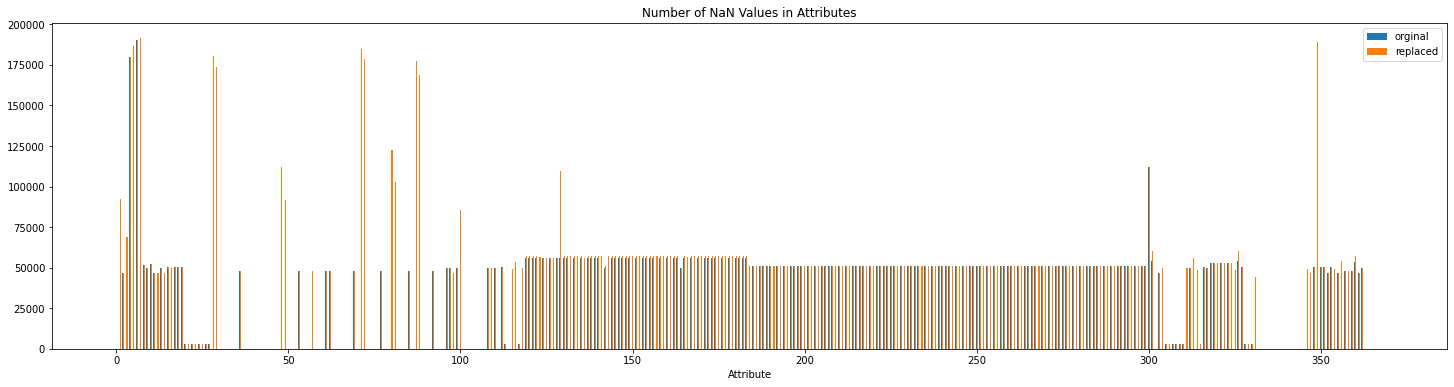

In [ ]:
X_axis = np.arange(len(original_nan))
f, ax = plt.subplots(figsize=(25, 6))
plt.bar(X_axis - 0.1, original_nan, 0.3, label = 'orginal')
plt.bar(X_axis + 0.1, replaced_nan, 0.3, label = 'replaced')
  
#plt.xticks(X_axis, original_nan.index,rotation='vertical')
plt.xlabel("Attribute")
plt.title("Number of NaN Values in Attributes")
plt.legend()
plt.show()

#### 1.2.1 Missing values in columns

In [25]:
# Percentage of missing values
azdias_nan = azdias_replaced.isna().sum()
azdias_nan_perc = azdias_nan/len(azdias) * 100

In [26]:
azdias_nan

LNR                          0
AGER_TYP                677503
AKT_DAT_KL               73499
ALTER_HH                310267
ALTER_KIND1             810163
                         ...  
WOHNDAUER_2008           73499
WOHNLAGE                 93148
ZABEOTYP                     0
ANREDE_KZ                    0
ALTERSKATEGORIE_GROB         0
Length: 366, dtype: int64

In [27]:
azdias_nan_perc.sort_values(ascending=False)

ALTER_KIND4                99.864792
TITEL_KZ                   99.757636
ALTER_KIND3                99.307691
ALTER_KIND2                96.690047
D19_TELKO_ANZ_12           96.271295
                             ...    
D19_VERSI_DATUM             0.000000
D19_VERSI_OFFLINE_DATUM     0.000000
D19_VERSI_ONLINE_DATUM      0.000000
D19_VERSICHERUNGEN          0.000000
LNR                         0.000000
Length: 366, dtype: float64

Text(0, 0.5, 'Percentage of missing data %')

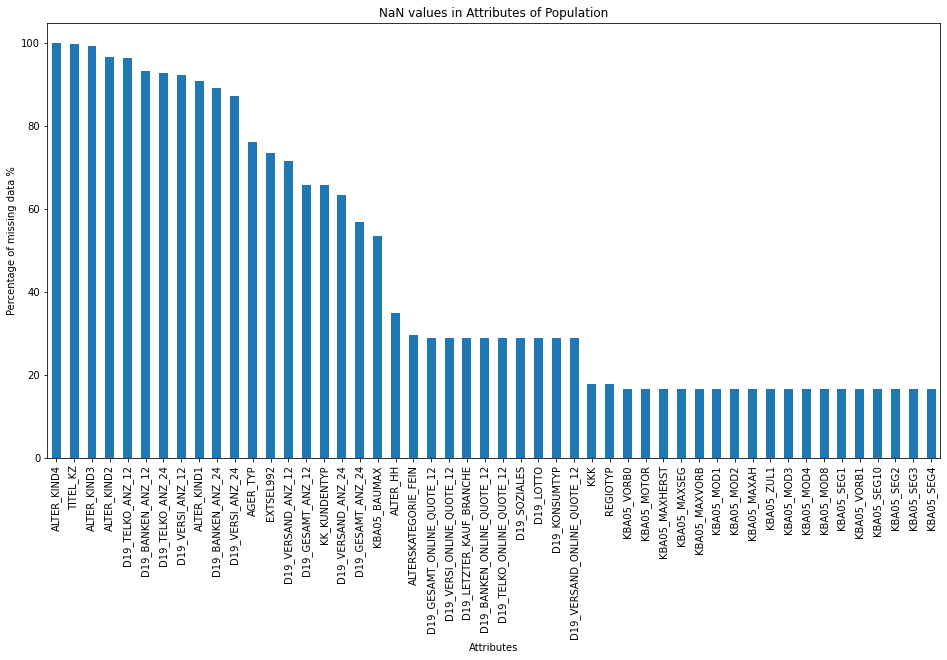

In [28]:
ax = azdias_nan_perc.sort_values(ascending=False).head(50).plot(kind='bar', figsize=(16,8), title='NaN values in Attributes of Population')
ax.set_xlabel("Attributes")
ax.set_ylabel("Percentage of missing data %")

In [29]:
drop_cols_azdias = list(azdias_nan_perc[azdias_nan_perc>20].index)
drop_cols_azdias

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [30]:
# Percentage of missing values
customers_nan = customers_replaced.isna().sum()
customers_nan_perc = customers_nan/len(customers) * 100

In [31]:
customers_nan_perc.sort_values(ascending=False)

ALTER_KIND4                99.876860
ALTER_KIND3                99.334732
TITEL_KZ                   98.793647
ALTER_KIND2                97.338927
D19_TELKO_ANZ_12           96.251017
                             ...    
D19_VERSI_DATUM             0.000000
D19_VERSI_OFFLINE_DATUM     0.000000
D19_VERSI_ONLINE_DATUM      0.000000
D19_VERSICHERUNGEN          0.000000
LNR                         0.000000
Length: 366, dtype: float64

Text(0, 0.5, 'Percentage of missing data %')

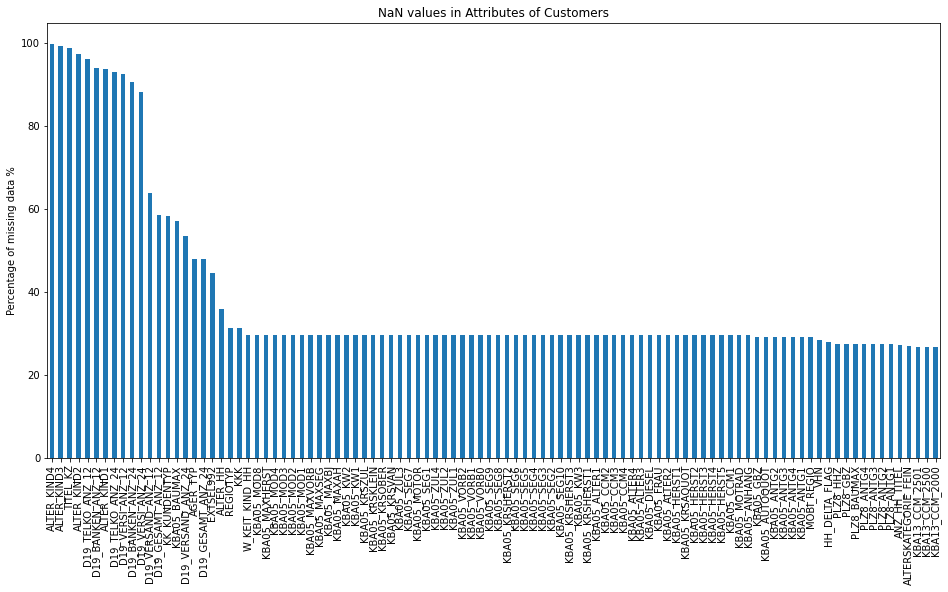

In [32]:
ax = customers_nan_perc.sort_values(ascending=False).head(100).plot(kind='bar', figsize=(16,8), title='NaN values in Attributes of Customers')
ax.set_ylabel("Percentage of missing data %")

In [33]:
drop_cols_customers = list(customers_nan_perc[customers_nan_perc>30].index)
drop_cols_customers

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'KKK',
 'REGIOTYP',
 'TITEL_KZ']

In [34]:
drop_cols=set(list(customers_nan_perc[customers_nan_perc>30].index)+ list(azdias_nan_perc[azdias_nan_perc>20].index))
drop_cols

{'AGER_TYP',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KKK',
 'KK_KUNDENTYP',
 'REGIOTYP',
 'TITEL_KZ'}

In [35]:
drop_cols=list(drop_cols)

In [36]:
azdias_replaced.drop(drop_cols, axis=1, inplace=True)

In [ ]:
customers_replaced.drop(drop_cols, axis=1, inplace=True)

In [ ]:
customers_replaced

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,9628,9.0,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,143872,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,...,4.0,8.0,8.0,5.0,6.0,9.0,1.0,3,1,3
191648,154563,2.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,6.0,...,2.0,10.0,7.0,4.0,NaN,9.0,3.0,3,2,4
191649,148813,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,7.0,...,1.0,8.0,8.0,5.0,3.0,9.0,3.0,3,1,4
191650,148852,1.0,4.0,0.0,0.0,4.0,3.0,0.0,3.0,3.0,...,3.0,1.0,1.0,1.0,4.0,9.0,2.0,3,2,3


In [ ]:
azdias_replaced.shape

(891221, 334)

#### 1.2.2 Missing values in rows
There are a lot missing values in rows

In [ ]:
# Percentage of missing values
azdias_nrow = azdias_replaced.isna().sum(axis=1)
azdias_nrow_perc = azdias_nrow /len(azdias_replaced.columns) * 100

In [ ]:
azdias_nrow_perc.sort_values(ascending=False)

472919    73.353293
643174    72.754491
732775    72.754491
451655    72.455090
281305    72.455090
            ...    
542793     0.000000
542792     0.000000
542790     0.000000
542782     0.000000
445610     0.000000
Length: 891221, dtype: float64

In [ ]:
azdias_replaced[azdias_nrow_perc>50]

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
11,645169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
14,612565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3
17,612577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
24,703164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891172,706647,9.0,2.0,0.0,3.0,2.0,2.0,0.0,3.0,7.0,...,NaN,3.0,6.0,7.0,1.0,4.0,3.0,4,2,1
891173,706649,6.0,5.0,0.0,0.0,2.0,4.0,0.0,NaN,6.0,...,NaN,7.0,6.0,3.0,6.0,2.0,2.0,3,1,4
891175,706673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
891185,825637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,3


In [ ]:
drop_rows_azdias = azdias_nrow_perc[azdias_nrow_perc>50].index
len(drop_rows_azdias)

99977

In [ ]:
azdias_replaced.drop(drop_rows_azdias, axis=0, inplace=True)

In [ ]:
azdias_replaced

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,5.0,15.0,0.0,0.0,1.0,11.0,0.0,NaN,6.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,9.0,11.0,0.0,0.0,1.0,11.0,0.0,4.0,7.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,1.0,3.0,0.0,0.0,0.0,3.0,0.0,2.0,5.0,...,2.0,7.0,10.0,8.0,NaN,5.0,7.0,4,2,2
891219,825776,9.0,7.0,0.0,1.0,1.0,5.0,0.0,4.0,2.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [ ]:
# Percentage of missing values
customers_nrow = customers_replaced.isnull().sum(axis=1)
customers_nrow_perc = customers_nrow /len(customers_replaced.columns) * 100

In [ ]:
customers_nrow_perc.sort_values(ascending=False)

128189    73.353293
134876    73.053892
13188     72.455090
33815     72.455090
2794      72.455090
            ...    
113052     0.000000
113053     0.000000
113054     0.000000
113055     0.000000
0          0.000000
Length: 191652, dtype: float64

In [ ]:
drop_rows_customers = list(customers_nrow_perc[customers_nrow_perc>50].index)
len(drop_rows_customers)

50788

In [ ]:
customers_replaced.drop(drop_rows_customers, axis=0, inplace=True)

In [ ]:
customers_replaced

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
2,143872,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,...,4.0,8.0,8.0,5.0,6.0,9.0,1.0,3,1,3
191648,154563,2.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,6.0,...,2.0,10.0,7.0,4.0,NaN,9.0,3.0,3,2,4
191649,148813,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,7.0,...,1.0,8.0,8.0,5.0,3.0,9.0,3.0,3,1,4
191650,148852,1.0,4.0,0.0,0.0,4.0,3.0,0.0,3.0,3.0,...,3.0,1.0,1.0,1.0,4.0,9.0,2.0,3,2,3


### 1.3  Clean and Encode with categorical data

In [ ]:
customers_replaced.dtypes.value_counts()

float64    254
int64       77
object       3
dtype: int64

In [ ]:
customers_replaced.select_dtypes(['object'])

,CAMEO_DEU_2015,EINGEFUEGT_AM,OST_WEST_KZ
0,1A,1992-02-12 00:00:00,W
2,5D,1992-02-10 00:00:00,W
3,4C,1992-02-10 00:00:00,W
4,7B,1992-02-12 00:00:00,W
5,5D,1992-02-10 00:00:00,W
...,...,...,...
191647,1C,1992-02-10 00:00:00,W
191648,5B,1997-03-06 00:00:00,W
191649,4D,1992-02-10 00:00:00,W
191650,4C,1992-02-10 00:00:00,W


In [ ]:
# only keep the year of EINGEFUEGT_AM to simply
azdias_replaced['EINGEFUEGT_AM'] = pd.to_datetime(azdias_replaced['EINGEFUEGT_AM'])
azdias_replaced['EINGEFUEGT_AM_YEAR'] = azdias_replaced['EINGEFUEGT_AM'].dt.year

customers_replaced['EINGEFUEGT_AM'] = pd.to_datetime(customers_replaced['EINGEFUEGT_AM'])
customers_replaced['EINGEFUEGT_AM_YEAR'] = customers_replaced['EINGEFUEGT_AM'].dt.year

In [ ]:
azdias_replaced.drop(['CAMEO_DEU_2015','EINGEFUEGT_AM'] , axis=1, inplace=True)
customers_replaced.drop(['CAMEO_DEU_2015','EINGEFUEGT_AM'] , axis=1, inplace=True)

In [ ]:
azdias_replaced.select_dtypes(['object'])

,OST_WEST_KZ
1,W
2,W
3,W
4,W
5,W
...,...
891216,W
891217,W
891218,W
891219,W


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
azdias_replaced['OST_WEST_KZ'] = le.fit_transform(azdias_replaced['OST_WEST_KZ'])
customers_replaced['OST_WEST_KZ'] = le.fit_transform(customers_replaced['OST_WEST_KZ'])

In [ ]:
azdias_replaced['OST_WEST_KZ'].value_counts()

1    623913
0    167331
Name: OST_WEST_KZ, dtype: int64

In [ ]:
customers_replaced['OST_WEST_KZ'].value_counts()

1    129601
0     11263
Name: OST_WEST_KZ, dtype: int64

In [ ]:
customers_replaced

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR
0,9626,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,1992
2,143872,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,1992
3,143873,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4,1992
4,143874,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,1992
5,143888,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,...,8.0,8.0,5.0,6.0,9.0,1.0,3,1,3,1992
191648,154563,2.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,6.0,...,10.0,7.0,4.0,NaN,9.0,3.0,3,2,4,1997
191649,148813,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,7.0,...,8.0,8.0,5.0,3.0,9.0,3.0,3,1,4,1992
191650,148852,1.0,4.0,0.0,0.0,4.0,3.0,0.0,3.0,3.0,...,1.0,1.0,1.0,4.0,9.0,2.0,3,2,3,1992


In [ ]:
# LNR seems no spetial meaning, so drop it to simply
azdias_replaced.drop(['LNR'] , axis=1, inplace=True)
customers_replaced.drop(['LNR'] , axis=1, inplace=True)

In [ ]:
print('Original data')
print('General Population Dataset Shape: ', azdias.shape)
print('Customer Dataset Shape: ', customers.shape)
print('Tidy-up data')
print('General Population Dataset Shape: ', azdias_replaced.shape)
print('Customer Dataset Shape: ', customers_replaced.shape)

Original data
General Population Dataset Shape:  (891221, 366)
Customer Dataset Shape:  (191652, 369)
Tidy-up data
General Population Dataset Shape:  (791244, 332)
Customer Dataset Shape:  (140864, 332)


### 1.4  Filling NaN data

Firstly try to fill NaN with mean values to simply

In [ ]:
azdias_replaced.fillna(azdias_replaced.mean(), inplace=True)
customers_replaced.fillna(customers_replaced.mean(), inplace=True)

In [ ]:
# Count how many columns having nan values
print((azdias_replaced.isna().sum()>0).sum(), "columns in azidas have nan.")
print((customers_replaced.isna().sum()>0).sum(), "columns in customers have nan.")

0 columns in azidas have nan.
0 columns in customers have nan.


### 1.5 Scale and Preprocessing data 

In [ ]:
# Search in the Internet, MinMaxScaler seems more suitable than StandardScaler here
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
azdias_cleaned = pd.DataFrame(scaler.fit_transform(azdias_replaced), columns=azdias_replaced.columns)
customers_cleaned = pd.DataFrame(scaler.fit_transform(customers_replaced), columns=customers_replaced.columns)

In [ ]:
azdias_cleaned.to_csv('data/Udacity_AZDIAS_clean.csv', index=False, sep=';')
customers_cleaned.to_csv('data/Udacity_CUSTOMERS_clean.csv', index=False, sep=';')

## Part 2: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 2.1 Dimensionality Reduction PCA
Using Principal component analysis (PCA) to reduce the complexity of datasets before further analysis

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
azdias_cleaned=pd.read_csv('data/Udacity_AZDIAS_clean.csv', sep=';')
customers_cleaned=pd.read_csv('data/Udacity_CUSTOMERS_clean.csv', sep=';')

In [ ]:
# attributes info 
attributes_info = pd.read_excel('/content/gdrive/My Drive/aws/data/DIAS Information Levels - Attributes 2017.xlsx', header=1)

In [ ]:
azdias_cleaned.shape

(791244, 332)

In [ ]:
pca = PCA()
PCs = pca.fit_transform(azdias_cleaned)  

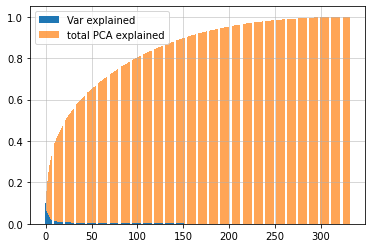

In [ ]:
fig = plt.figure(figsize=(6, 4))
ax = plt.axes()
ax.bar(np.arange(0, azdias_cleaned.shape[1]), pca.explained_variance_ratio_, color="C0",
       label=r"Var explained", zorder=3)
ax.bar(np.arange(0, azdias_cleaned.shape[1]), np.cumsum(pca.explained_variance_ratio_), color="C1",
       label="total PCA explained", zorder=1, alpha=0.7) 
ax.legend()
ax.grid(lw=0.5, zorder=0)

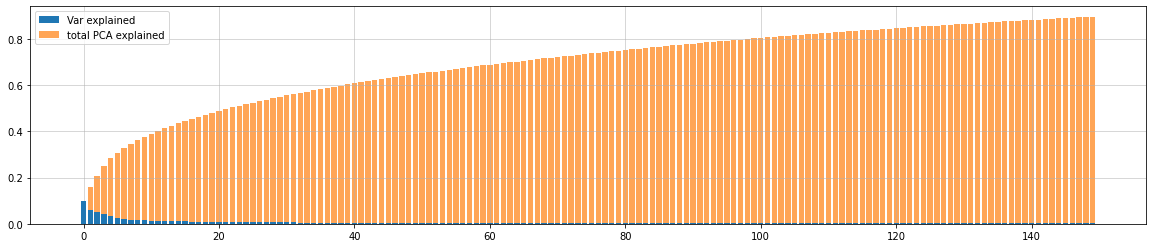

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = plt.axes()
ax.bar(np.arange(0, 150), pca.explained_variance_ratio_[:150], color="C0",
       label=r"Var explained", zorder=3)
ax.bar(np.arange(0, 150), np.cumsum(pca.explained_variance_ratio_[:150]), color="C1",
       label="total PCA explained", zorder=1, alpha=0.7) 
ax.legend()
ax.grid(lw=0.5, zorder=0)

Since 150 components contain almost 90% of the infomation in Azidas, so I set n_components=150 into PCA therefore.

In [ ]:
np.cumsum(pca.explained_variance_ratio_)[150]

0.8970005421196684

In [ ]:
pca = PCA(n_components=150)
azdias_pca = pca.fit_transform(azdias_cleaned)  

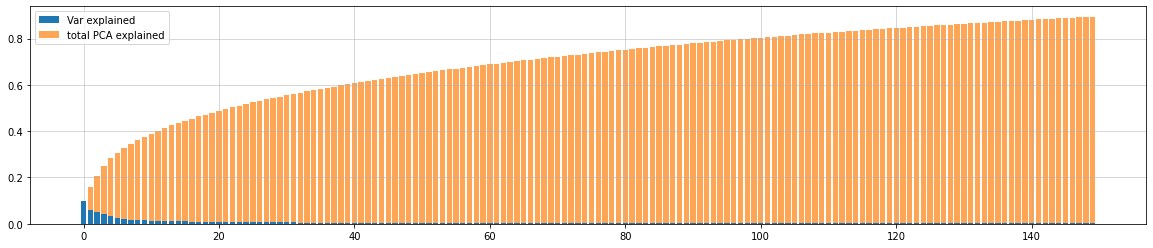

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = plt.axes()
ax.bar(np.arange(0, 150), pca.explained_variance_ratio_, color="C0",
       label=r"Var explained", zorder=3)
ax.bar(np.arange(0, 150), np.cumsum(pca.explained_variance_ratio_), color="C1",
       label="total PCA explained", zorder=1, alpha=0.7) 
ax.legend()
ax.grid(lw=0.5, zorder=0)

In [ ]:
customers_pca = pca.transform(customers_cleaned)

In [ ]:
pca.components_.shape

(150, 332)

In [ ]:
feature_weights = dict(zip(azdias_cleaned.columns.values, pca.components_[0]))
sorted_feature_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])

In [ ]:
len(sorted_feature_weights)

332

In [ ]:
pd.DataFrame(sorted_feature_weights).iloc[np.r_[:3,  -3, -2, -1],:]

,0,1
0,KBA13_BAUMAX,-0.165561
1,KBA13_ANTG4,-0.162659
2,PLZ8_ANTG4,-0.158073
329,KBA05_ANTG1,0.153032
330,LP_STATUS_GROB,0.174057
331,LP_STATUS_FEIN,0.182556


In [ ]:
def plot_feature_weights(df, pca, i):
    feature_weights = dict(zip(df.columns.values, pca.components_[i]))
    sorted_feature_weights = sorted(feature_weights.items(), key = lambda kv: kv[1])
    
    features = pd.DataFrame(sorted_feature_weights).iloc[np.r_[:4, -4, -3, -2, -1],:]
    feature_names = features[0].values
    weights = features[1].values

    ax = sns.barplot(x=weights, y=feature_names)
    ax.set(xlabel="Weight", ylabel="Attribute", title='PC {0} explains {1:.3f}'.format(i+1,pca.explained_variance_ratio_[i]))

    feature_info=[]
    for feature in feature_names :
        if feature in attributes_info.Attribute.values:
            feature_info.append(attributes_info[attributes_info.Attribute == feature].Description.values[0])
        else:
           feature_info.append("No description in attributes_info")

    feature_df = {"Attribute":feature_names, "Description":feature_info, "Attribute Weight":weights}
    feature_df = pd.DataFrame(feature_df)
    feature_df.sort_values("Attribute Weight", inplace=True, ascending=False)

    return feature_df 

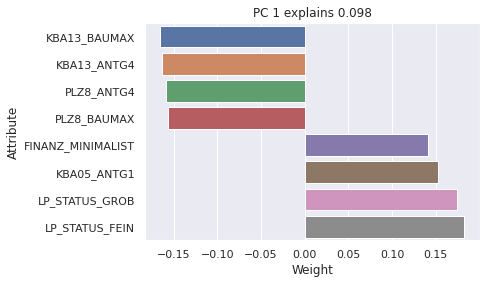

In [ ]:
feature_df=plot_feature_weights(azdias_cleaned, pca, 0)

In [ ]:
feature_df

,Attribute,Description,Attribute Weight
7,LP_STATUS_FEIN,social status fine,0.182556
6,LP_STATUS_GROB,social status rough,0.174057
5,KBA05_ANTG1,number of 1-2 family houses in the cell,0.153032
4,FINANZ_MINIMALIST,financial typology: low financial interest,0.141127
3,PLZ8_BAUMAX,most common building-type within the PLZ8,-0.156454
2,PLZ8_ANTG4,number of >10 family houses in the PLZ8,-0.158073
1,KBA13_ANTG4,No description in attributes_info,-0.162659
0,KBA13_BAUMAX,No description in attributes_info,-0.165561


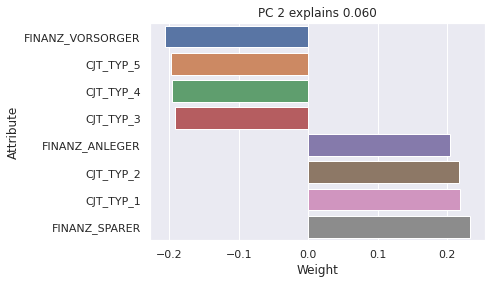

In [ ]:
feature_df=plot_feature_weights(azdias_cleaned, pca, 1)

In [ ]:
feature_df

,Attribute,Description,Attribute Weight
7,FINANZ_SPARER,financial typology: money saver,0.232331
6,CJT_TYP_1,No description in attributes_info,0.218414
5,CJT_TYP_2,No description in attributes_info,0.216262
4,FINANZ_ANLEGER,financial typology: investor,0.203230
3,CJT_TYP_3,No description in attributes_info,-0.192075
2,CJT_TYP_4,No description in attributes_info,-0.195985
1,CJT_TYP_5,No description in attributes_info,-0.197370
0,FINANZ_VORSORGER,financial typology: be prepared,-0.205450


### 2.2 K-Means Clustering

*   K-Means is clustering algorithm to average of sum of squared errors (SSE) within-cluster distances

*   Elbow method is to identify the number of clusters for K-Means clustering on the PCA-transformed data


In [ ]:
from sklearn.cluster import KMeans
import time

In [ ]:
%%time
k_sse= []
for i in range(2,20):
    start = time.time()
    kmeans = KMeans(n_clusters = i, random_state = 42, n_init="auto")
    kmeans.fit(azdias_pca)
    k_sse.append(kmeans.inertia_)
    print('nb of K : {0}'.format(i))
    print("Time: {:.2f} sec.".format(time.time()-start))

nb of K : 2
Time: 7.30 sec.
nb of K : 3
Time: 18.82 sec.
nb of K : 4
Time: 12.54 sec.
nb of K : 5
Time: 20.87 sec.
nb of K : 6
Time: 11.02 sec.
nb of K : 7
Time: 41.71 sec.
nb of K : 8
Time: 31.00 sec.
nb of K : 9
Time: 77.71 sec.
nb of K : 10
Time: 39.98 sec.
nb of K : 11
Time: 49.42 sec.
nb of K : 12
Time: 52.06 sec.
nb of K : 13
Time: 80.34 sec.
nb of K : 14
Time: 57.88 sec.
nb of K : 15
Time: 43.48 sec.
nb of K : 16
Time: 73.96 sec.
nb of K : 17
Time: 54.23 sec.
nb of K : 18
Time: 109.66 sec.
nb of K : 19
Time: 67.93 sec.
CPU times: user 21min 40s, sys: 17.2 s, total: 21min 57s
Wall time: 14min 9s


In [ ]:
def plot_elbow(scores):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    
    ax.plot(np.arange(2,len(scores)+2), scores, marker = "o")
    ax.set_xlabel("Number of Clusters")
    ax.set_title("SSE vs K (Nb of clusters)")  
    plt.show()

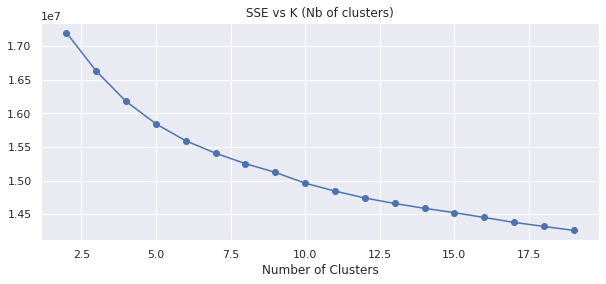

In [ ]:
plot_elbow(k_sse)

In [ ]:
kmeans = KMeans( n_clusters=10, random_state=42, n_init="auto")
azdias_pred = pd.Series(kmeans.fit_predict(azdias_pca))
customers_pred = pd.Series(kmeans.predict(customers_pca))

In [ ]:
azdias_pred

0         2
1         2
2         5
3         6
4         5
         ..
791239    0
791240    3
791241    0
791242    3
791243    5
Length: 791244, dtype: int32

In [ ]:
df_cluster = pd.DataFrame([])
df_cluster["Population"] = azdias_pred.value_counts().sort_index()
df_cluster["Customers"] = customers_pred.value_counts().sort_index()
df_cluster

,Population,Customers
0,83603,5391
1,58271,22018
2,107453,783
3,82621,1936
4,51886,2707
5,101523,24511
6,64531,3451
7,91388,59342
8,49877,3365
9,100091,17360


In [ ]:
df_cluster["Prop_population"] = df_cluster["Population"]/df_cluster["Population"].sum()*100
df_cluster["Prop_customers"] = df_cluster["Customers"]/df_cluster["Customers"].sum()*100

In [ ]:
df_cluster

,Population,Customers,Prop_population,Prop_customers
0,83603,5391,10.566020,3.827096
1,58271,22018,7.364479,15.630679
2,107453,783,13.580261,0.555855
3,82621,1936,10.441912,1.374375
4,51886,2707,6.557522,1.921712
5,101523,24511,12.830808,17.400471
6,64531,3451,8.155638,2.449881
7,91388,59342,11.549914,42.127158
8,49877,3365,6.303618,2.388829
9,100091,17360,12.649827,12.323944


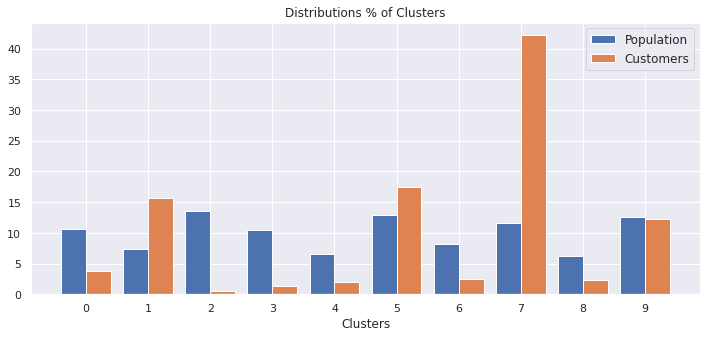

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.bar(df_cluster.index-.2,df_cluster['Prop_population'],0.4,label='Population')
plt.bar(df_cluster.index+.2,df_cluster['Prop_customers'],0.4,label='Customers')
plt.legend(fontsize=12)
aa=plt.xticks(np.arange(10))
aa=plt.xlabel('Clusters')
aa=plt.title('Distributions % of Clusters')

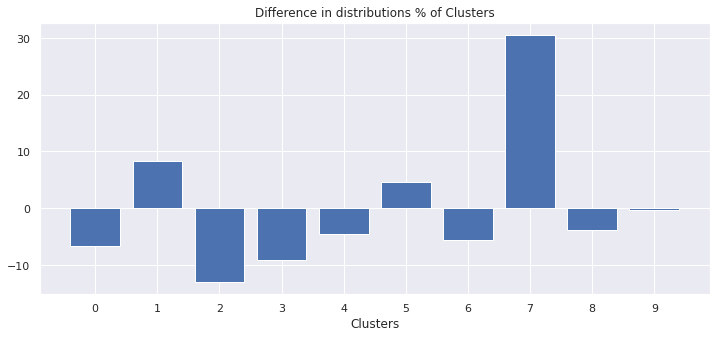

In [ ]:
fig = plt.figure(figsize=(12,5))
plt.bar(df_cluster.index,df_cluster['Prop_customers']-df_cluster['Prop_population'])
aa=plt.xticks(np.arange(10))
aa=plt.xlabel('Clusters')
aa=plt.title('Difference in distributions % of Clusters')

In [ ]:
kmeans.cluster_centers_.shape

(10, 150)

## Part 3: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import learning_curve

In [3]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv')

/home/feyan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
mailout_train

,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4


In [5]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

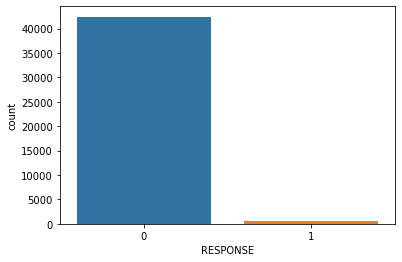

In [10]:
sns.countplot(x=mailout_train["RESPONSE"])

In [ ]:
labels = mailout_train["RESPONSE"]

### 3.1 Data preprocessing

Same columns as azdias expect for 'Unnamed: 0' and 'RESPONSE', so same data preprocessing will be done to mailout_train

In [ ]:
azdias_cleaned=pd.read_csv('data/Udacity_AZDIAS_clean.csv', sep=';')

In [ ]:
mailout_train.drop(['Unnamed: 0', 'RESPONSE'] , axis=1, inplace=True)

In [ ]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,3.0,1.0,1.0,1.0,4.0,8.0,7.0,1,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,3.0,1.0,1.0,1.0,5.0,9.0,7.0,1,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,3.0,1.0,2.0,1.0,2.0,9.0,7.0,1,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,3.0,2.0,3.0,4.0,2.0,9.0,2.0,3,2,4


In [ ]:
def data_whole_prepro(df):
    df_replaced = df.copy()

    # Dtype warning
    for col_names in ['CAMEO_INTL_2015','CAMEO_DEUG_2015']:
        convert_nan(df_replaced,col_names)

    # convert unknown base on attribute info dict
    df_replaced = convert_unknown(df_replaced,unknown_dict)

    # Encode with categorical data
    df_replaced['EINGEFUEGT_AM'] = pd.to_datetime(df_replaced['EINGEFUEGT_AM'])
    df_replaced['EINGEFUEGT_AM_YEAR'] = df_replaced['EINGEFUEGT_AM'].dt.year
    le = LabelEncoder()
    df_replaced['OST_WEST_KZ'] = le.fit_transform(df_replaced['OST_WEST_KZ'].astype(str))

    # Dropping columns which are not in azdias
    cols_drop = [col for col in df_replaced.columns if col not in azdias_cleaned.columns]    
    df_replaced.drop(cols_drop, axis=1, inplace=True)   

    # Fill Missing data by mean
    df_replaced.fillna(df_replaced.mean(), inplace=True)

    return df_replaced

In [ ]:
mailout_train_replaced=data_whole_prepro(mailout_train)

In [ ]:
mailout_train_replaced.shape

(42962, 332)

In [ ]:
# Count how many columns having nan values
print((mailout_train_replaced.isna().sum()>0).sum(), "columns in mailout_train have nan.")

0 columns in mailout_train have nan.


### 3.2 Scale and split data 

In [ ]:
# MinmaxScaler
scaler = MinMaxScaler()
mailout_train_cleaned = pd.DataFrame(scaler.fit_transform(mailout_train_replaced), columns=mailout_train_replaced.columns)

In [ ]:
# StandardScaler
scaler = StandardScaler()
mailout_train_cleaned = pd.DataFrame(scaler.fit_transform(mailout_train_replaced), columns=mailout_train_replaced.columns)

In [ ]:
# Split data into train, validation
X_train, X_val, y_train, y_val = train_test_split(mailout_train_cleaned, labels, test_size=0.2)

In [ ]:
X_train

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR
34390,0.000000,0.002283,0.000000,0.000000,0.125000,0.002710,0.000000,0.125000,0.833333,0.12500,...,0.200000,0.416667,0.300000,0.400000,1.000000,0.375000,0.6,1.0,0.375,0.041667
42830,0.065655,0.015311,0.002479,0.014832,0.084045,0.017008,0.004793,0.255652,0.542796,0.49559,...,0.331864,0.292163,0.211696,0.718064,0.966243,0.507461,0.4,1.0,0.000,0.094351
27526,0.000000,0.015311,0.002479,0.000000,0.041667,0.017008,0.000000,0.255652,0.542796,0.49559,...,0.800000,0.666667,0.500000,0.718064,1.000000,0.507461,0.4,0.0,0.375,0.094351
28984,0.065655,0.015311,0.002479,0.014832,0.084045,0.017008,0.004793,0.255652,0.542796,0.49559,...,0.331864,0.292163,0.211696,0.718064,0.966243,0.507461,0.4,0.0,0.000,0.094351
35125,0.065655,0.015311,0.002479,0.014832,0.084045,0.017008,0.004793,0.255652,0.542796,0.49559,...,0.331864,0.292163,0.211696,0.718064,0.966243,0.507461,0.4,1.0,0.000,0.094351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25636,0.065655,0.015311,0.002479,0.014832,0.084045,0.017008,0.004793,0.255652,0.542796,0.49559,...,0.331864,0.292163,0.211696,0.718064,0.966243,0.507461,0.4,1.0,0.125,0.094351
13008,0.065655,0.015311,0.002479,0.014832,0.084045,0.017008,0.004793,0.255652,0.542796,0.49559,...,0.331864,0.292163,0.211696,0.718064,0.966243,0.507461,0.4,0.0,0.000,0.094351
40509,0.000000,0.002283,0.000000,0.000000,0.208333,0.002710,0.000000,0.250000,1.000000,0.25000,...,0.000000,0.000000,0.000000,0.200000,1.000000,0.875000,0.8,1.0,0.000,0.041667
5315,0.000000,0.125571,0.000000,0.000000,0.041667,0.146341,0.000000,0.125000,0.166667,0.62500,...,0.700000,0.833333,0.700000,0.600000,1.000000,0.500000,0.4,1.0,0.375,0.041667


### 3.3 Model Evaluation and Validation

roc_auc_score is good at binary classification

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [ ]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
  
    model = model.fit(X_train, y_train)   
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
  
    return roc

In [ ]:
models = [
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier()),
         ("GradientBoostingClassifier", GradientBoostingClassifier()),
         ("AdaBoostClassifier", AdaBoostClassifier())
         ]

In [ ]:
results = {"Model":[], "AUCROC_score":[]}

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)

In [ ]:
# Minmaxscaler
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,DecisionTreeClassifier,0.484427
1,RandomForestClassifier,0.562836
2,GradientBoostingClassifier,0.665879
3,AdaBoostClassifier,0.636314


In [ ]:
# StandardScaler
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,DecisionTreeClassifier,0.525455
1,RandomForestClassifier,0.559589
2,GradientBoostingClassifier,0.647368
3,AdaBoostClassifier,0.621618


In [ ]:
# no scaling
results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,DecisionTreeClassifier,0.482154
1,RandomForestClassifier,0.562957
2,GradientBoostingClassifier,0.675019
3,AdaBoostClassifier,0.586191


In [ ]:
for name, model in models[0]:
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.title(name)
    plt.xlabel("% of training set")

    plt.yticks(np.arange(0.4, 1.02, 0.1))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

AUC train score = 0.99
AUC validation score = 0.5



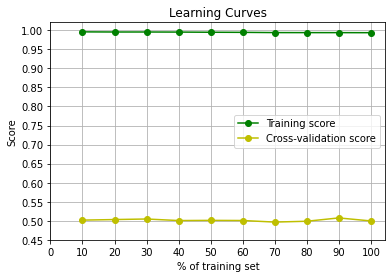

AUC train score = 0.97
AUC validation score = 0.54



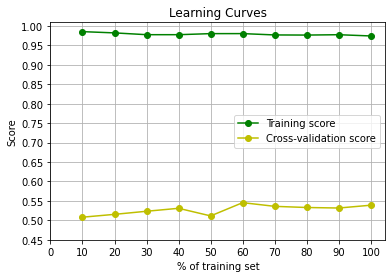

AUC train score = 0.92
AUC validation score = 0.65



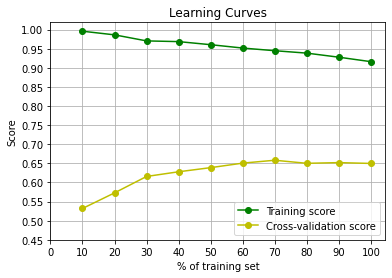

AUC train score = 0.8
AUC validation score = 0.62



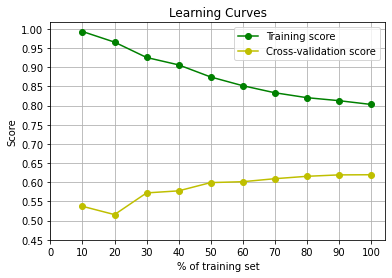

In [ ]:
for name, model in models:
    train_sizes, train_scores, test_scores = learning_curve(
        model, mailout_train_cleaned, labels, scoring = 'roc_auc', train_sizes=np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(train_scores_mean[-1].round(2)))
    print("AUC validation score = {}".format(test_scores_mean[-1].round(2)))
    plt.grid()

    plt.plot(np.linspace(.1, 1.0, 10)*100, train_scores_mean, 'o-', color="g",
             label="Training score")
    plt.plot(np.linspace(.1, 1.0, 10)*100, test_scores_mean, 'o-', color="y",
             label="Cross-validation score")

    plt.title(name)
    plt.xlabel("% of training set")

    plt.yticks(np.arange(0.4, 1.02, 0.1))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    print("")
    plt.show()

### 3.4 Grid search for Gradient Boosting Classifier

In [ ]:
GBC_classifier = GradientBoostingClassifier(random_state=0)
cv_sets = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
parameters = {'learning_rate':[0.001,0.01],
             'n_estimators' : [50,100,200],
             'max_depth':[3,5]}
GBC_obj = GridSearchCV(GBC_classifier, 
                             parameters, 
                             scoring = "roc_auc", 
                             cv = cv_sets)
GBC_fit = GBC_obj.fit(X_train, y_train)
GBC_opt = GBC_fit.best_estimator_

In [ ]:
GBC_classifier = GradientBoostingClassifier(random_state=0)
cv_sets = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
parameters = {'learning_rate':[0.1],
             'n_estimators' : [100,200],
             'max_depth':[3,8]}
GBC_obj = GridSearchCV(GBC_classifier, 
                             parameters, 
                             scoring = "roc_auc", 
                             cv = cv_sets)
GBC_fit = GBC_obj.fit(X_train, y_train)
GBC_opt = GBC_fit.best_estimator_

In [ ]:
print("Best Score: ", GBC_fit.best_score_)
print("Best Params: ", GBC_fit.best_params_)

In [ ]:
preds = GBC_opt.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

In [ ]:
print("Best Score: ", GBC_fit.best_score_)
print("Best Params: ", GBC_fit.best_params_)

Best Score:  0.701002284841896
Best Params:  {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
preds = GBC_opt.predict_proba(X_val)[:,1]
print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.7364


### 3.5 Evaluate Test dataset

In [ ]:
mailout_test = pd.read_csv('/content/gdrive/My Drive/aws/data/Udacity_MAILOUT_052018_TEST.csv')

<ipython-input-30-7b711ae634d2>:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('/content/gdrive/My Drive/aws/data/Udacity_MAILOUT_052018_TEST.csv')


In [ ]:
mailout_test_replaced=data_whole_prepro(mailout_test)

In [ ]:
mailout_test_replaced

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,EINGEFUEGT_AM_YEAR
0,1.00000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,6.000000,2.000000,...,5.000000,6.000000,3.000000,6.000000,9.000000,3.00000,3,1,4,1993.000000
1,1.00000,20.000000,0.000000,0.000000,1.000000,21.000000,0.000000,4.000000,7.000000,5.000000,...,5.000000,2.000000,1.000000,6.000000,9.000000,5.00000,3,1,4,1992.000000
2,9.00000,2.000000,0.000000,0.000000,4.000000,2.000000,0.000000,4.000000,1.000000,7.000000,...,9.000000,6.000000,3.000000,2.000000,9.000000,4.00000,3,2,4,1992.000000
3,7.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,1.000000,2.000000,...,6.000000,6.000000,3.000000,4.587484,9.000000,2.00000,3,2,4,1992.000000
4,1.00000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,3.000000,6.000000,5.000000,...,2.000000,4.000000,3.000000,3.000000,9.000000,7.00000,4,2,4,1992.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42828,1.51889,6.749986,0.045666,0.090752,2.023481,6.331818,0.010934,3.039658,4.286827,4.967508,...,4.308682,4.488474,3.090078,4.587484,8.727437,4.08828,3,2,1,1993.288019
42829,1.00000,2.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000,6.000000,6.000000,...,10.000000,9.000000,6.000000,6.000000,9.000000,3.00000,3,1,4,1992.000000
42830,1.00000,1.000000,0.000000,2.000000,3.000000,1.000000,0.000000,3.000000,6.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,9.000000,3.00000,2,1,3,1992.000000
42831,1.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,4.000000,6.000000,1.000000,...,4.000000,4.000000,2.000000,6.000000,9.000000,3.00000,3,2,3,1992.000000


In [ ]:
preds = GBC_opt.predict_proba(mailout_test_replaced)[:,1]

In [ ]:
preds

array([0.0405689 , 0.05640786, 0.13600839, ..., 0.09648048, 0.05571342,
       0.07262492])